In [1]:
import numpy as np
import h5py
import itertools
import matplotlib.pyplot as plt
from corner import corner
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

tfk = tf.keras
tfd = tfp.distributions
tfb = tfp.bijectors

seed = 42
np.random.seed(seed)
tf.random.set_seed(seed)

2022-07-07 11:35:54.557281: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-07 11:35:54.557305: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
def sample_powerlaw(n_samples, slope, lo, hi):
    
    x = np.random.uniform(size=n_samples)
    
    return (lo**(slope+1) + x * (hi**(slope+1) - lo**(slope+1)))**(1/(slope+1))

def sample_data(n_dim, n_samples, slope, lo, hi, loc, scale, bounded_idxs=[1, 2]):
    
    n_bounded = len(bounded_idxs)
    n_unbounded = n_dim - n_bounded
    unbounded_idxs = list(set(range(n_dim)) - set(bounded_idxs))
    data = np.zeros([n_samples, n_dim])
    data[:, unbounded_idxs] = np.random.normal(
        loc=loc, scale=scale, size=[n_samples, n_unbounded],
        )
    data[:, bounded_idxs] = sample_powerlaw(
        [n_samples, n_bounded], slope, lo, hi,
        )
    
    return data

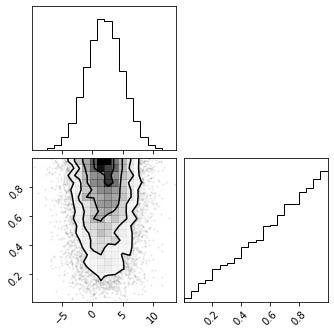

In [3]:
n_dim = 2
n_samples = 10000
slope = 1
lo = 0
hi = 1
loc = 2
scale = 3
bounded_idxs = [1]

data = sample_data(n_dim, n_samples, slope, lo, hi, loc, scale, bounded_idxs)

corner(data);

In [4]:
# Need to permute between flows
# For n_dim > 2, there are multiple choices
# But we have to ensure all outputs are moved

def all_permuted(n_dim):
    
    permutations = np.array(list(itertools.permutations(range(n_dim))))
    permuted = ~np.any(permutations == list(range(n_dim)), axis=1)
    
    return permutations[permuted]

In [5]:
permutations = all_permuted(n_dim)
permutations

array([[1, 0]])

In [6]:
n_flows = 5
n_layers = 1
n_neurons = 128
activation = 'relu' #tfa.activations.rrelu

bijectors = []

# We transform the bounded outputs at the end
# Adjust shift and scale to whatever domain you need
blockwise_bijectors = []
for i in range(n_dim):
    if i in bounded_idxs:
        sigmoid = tfb.Chain(
            #[tfb.Tanh(), tfb.Shift(shift=1.), tfb.Scale(scale=.5)],
            [tfb.Scale(scale=.5), tfb.Shift(shift=1.), tfb.Tanh()],
            )
        blockwise_bijectors.append(sigmoid)
    else:
        blockwise_bijectors.append(tfb.Identity())
blockwise_bijector = tfb.Blockwise(blockwise_bijectors, block_sizes=[1]*n_dim)
bijectors.append(blockwise_bijector)

for i in range(n_flows):
    bijectors.append(tfb.MaskedAutoregressiveFlow(tfb.AutoregressiveNetwork(
        params=2,
        hidden_units=[n_neurons]*n_layers,
        activation=activation,
        )))
    #bijectors.append(tfb.BatchNormalization(training=True))
    bijectors.append(tfb.Permute(list(reversed(range(n_dim)))))

bijector = tfb.Chain(bijectors)
distribution = tfd.MultivariateNormalDiag(loc=[0]*n_dim)
nf = tfd.TransformedDistribution(distribution=distribution, bijector=bijector)

2022-07-07 11:36:05.760366: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-07 11:36:05.760398: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-07 11:36:05.760418: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (phy-190401): /proc/driver/nvidia/version does not exist
2022-07-07 11:36:05.760752: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
# Check the correct dimensions are bounded
nf.sample(10000).numpy().min(axis=0), nf.sample(10000).numpy().max(axis=0)

(array([-6.6608281e+00,  7.4505806e-07], dtype=float32),
 array([5.286731, 1.      ], dtype=float32))

In [8]:
epochs = 10
batch_size = 100
learning_rate = 1e-3

x = tf.keras.Input(shape=[n_dim], dtype=tf.float32)
log_prob = nf.log_prob(x)

model = tf.keras.Model(
    inputs=x,
    outputs=log_prob,
    )

model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=learning_rate),
    loss=lambda _, log_prob: -log_prob,
    )

# callbacks = [
#     tfk.callbacks.ModelCheckpoint(
#         filepath='./5_nonconditional.hdf5',
#         monitor='val_loss',
#         mode='min',
#         save_weights_only=True,
#         save_best_only=True,
#         save_freq='epoch',
#         verbose=1,
#         ),
#     tfk.callbacks.CSVLogger(
#         './nf2.csv',
#         ),
#     tfk.callbacks.EarlyStopping(
#         monitor='val_loss',
#         min_delta=0,
#         patience=10,
#         mode='min',
#         baseline=None,
#         restore_best_weights=False,
#         verbose=1,
#         ),
#     ]

steps_per_epoch = n_samples // batch_size

result = model.fit(
    x=data, y=np.zeros(n_samples),
    validation_data=[
        sample_data(n_dim, n_samples, slope, lo, hi, loc, scale, bounded_idxs),
        np.zeros(n_samples),
        ],
    epochs=epochs,
    batch_size=batch_size,
    steps_per_epoch=steps_per_epoch,
    shuffle=True,
    verbose=1,
    #callbacks=callbacks,
    )

Epoch 1/10
100/100 [==============================] - 3s 10ms/step - loss: 2.9405 - val_loss: 2.3891
Epoch 2/10
100/100 [==============================] - 1s 5ms/step - loss: 2.3527 - val_loss: 2.3346
Epoch 3/10
100/100 [==============================] - 1s 6ms/step - loss: 2.3369 - val_loss: 2.3305
Epoch 4/10
100/100 [==============================] - 1s 5ms/step - loss: 2.3299 - val_loss: 2.3287
Epoch 5/10
100/100 [==============================] - 1s 6ms/step - loss: 2.3278 - val_loss: 2.3277
Epoch 6/10
100/100 [==============================] - 1s 6ms/step - loss: 2.3254 - val_loss: 2.3339
Epoch 7/10
100/100 [==============================] - 1s 8ms/step - loss: 2.3265 - val_loss: 2.3301
Epoch 8/10
100/100 [==============================] - 1s 7ms/step - loss: 2.3280 - val_loss: 2.3358
Epoch 9/10
100/100 [==============================] - 1s 7ms/step - loss: 2.3269 - val_loss: 2.3294
Epoch 10/10
100/100 [==============================] - 1s 5ms/step - loss: 2.3285 - val_loss: 2.330

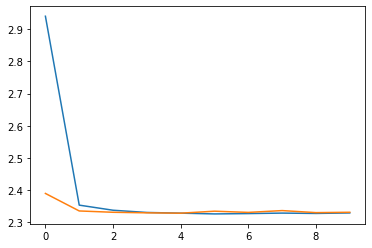

In [9]:
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss']);

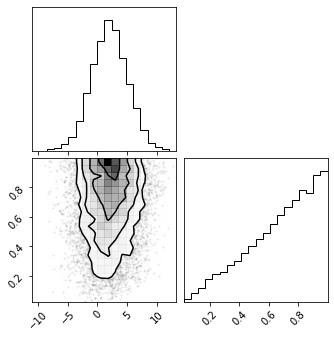

In [12]:
# Should be like the training data
corner(nf.sample(n_samples).numpy());

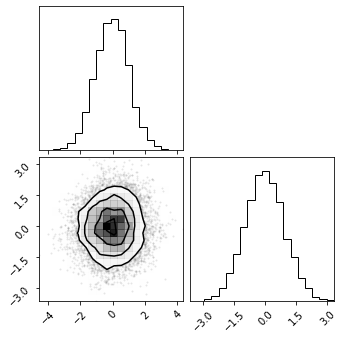

In [13]:
# Should be a Gaussian
samples = sample_data(
    n_dim, n_samples, slope, lo, hi, loc, scale, bounded_idxs,
    )
corner(bijector.inverse(samples).numpy());